# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- See the Learning curve, to determine if I'm limited by my sample size...
- Check classification instead of regression as well - will the stock go up or down? Looks imbalanced set though...
- Maybe try predicting only 6 months in advance instead of a year.
- Have time information for featuers, i.e. EPS_i+1 / EPS_i for a given stock
- Try and merge other currencies into USD columns? Might increase # stocks by a lot
- Need to take mean of December stock Price timeseries, so taht you don't e.g. by chance catch it at a high/low..
- Getting the stock data needs to be faster... wayy too slow

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [2]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")

#industry = 'Finance'
#tickers = pd.read_csv('csv/nasdaq/%s.csv'%industry,delimiter=",")
#tickers = tickers.loc[stocks['MarketCap']>1e7]  #exclude stocks with small market cap

tickers.head()

,Symbol,Company
0,A,Agilent Technologies
1,AA,Alcoa Inc
2,AACC,Asset Accep Cap Corp
3,AAI,Airtran Hldgs Inc
4,AAII,Alabama Aircraft Ind In


Testing

## Get Data

In [3]:
#small helper function for get_mean_frac_price_change
def first_and_last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BMS'), pd.date_range(date, periods=1, freq='BM')

#collects data from yahoo finance, gets mean fractional price change, averaged over the relevant month
def get_mean_frac_price_change(stock,current_date):
    ds = current_date.split('-')
    first_current, last_current = first_and_last_weekday_of_month(current_date)
    first_future, last_future = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    first_past, last_past = first_and_last_weekday_of_month('%d-%s'%(int(ds[0])-1, ds[1]))
    mean_current_price = DataReader(stock, 'yahoo', first_current, last_current)['Adj Close'].mean()
    mean_future_price = DataReader(stock, 'yahoo', first_future, last_future)['Adj Close'].mean()
    mean_past_price = DataReader(stock, 'yahoo', first_future, last_future)['Adj Close'].mean()
    return mean_future_price/mean_current_price, mean_current_price/mean_past_price
    
#simple progress bar
def progress_bar(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item

#scrape financial data from Morningstar
def get_stock_financials(stock,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK','OMR','AED']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    #scrape/load data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    #ignore if non-US stocks for consistency
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):            #delete if present
            return pd.DataFrame(columns=d.columns)         #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    #delete annoying repeated columns
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    #Get ratios of each feature from current and previous year
    i1,i2 = np.where(d['index'].str.contains("%d"%year))[0][0], np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
    current_date=d['index'].iloc[i1]
    ratios = pd.to_numeric(d.iloc[i1], errors='coerce')/pd.to_numeric(d.iloc[i2], errors='coerce')
    #ratios = d.iloc[i1].convert_objects(convert_numeric=True)/d.iloc[i2].convert_objects(convert_numeric=True)
    d = pd.DataFrame(ratios).transpose()
    MFFPC, MPFPC = get_mean_frac_price_change(stock,current_date)
    d['Stock'] = stock                                     #keep stock ticker
    d['Mean Past Fractional Price Change'] = MPFPC         #fractional price change (current/past) -> for features
    d['Mean Future Fractional Price Change'] = MFFPC       #fractional price change (future/current) -> for target
    return d
        
#Top-level function which acquires all the data
def get_data(ticker_csv,year,true_threshold):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_year%d_data.csv"%(ticker_loc,year))
        skip = np.loadtxt("%s_year%d_skip.csv"%(ticker_loc,year), dtype="str",delimiter=",")
        print "Loaded data from csv's..."
    except:
        print "Couldn't find DataFrame, scraping data from Morningstar..."
        #create empty dataframe with available columns
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],year).columns
        X = pd.DataFrame(columns=cols)
        skip = []
        for s in progress_bar(stocks["Symbol"], len(stocks["Symbol"])/10):
            try:
                _X = get_stock_financials(s,year)
                if _X.shape[1] > 1: #only append if alg actually recovered data
                    X = X.append(_X)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        #save to csv for ease of loading next time
        skip = np.asarray(skip)
        X.to_csv("%s_year%d_data.csv"%(ticker_loc,year))
        np.savetxt("%s_year%d_skip.csv"%(ticker_loc,year), skip, fmt="%s", delimiter=",")
    #create target
    y = np.zeros(X.shape[0])
    y[np.where(X['Mean Future Fractional Price Change']>true_threshold)] = 1
    return X, y, skip

Load the data below. This could take a minute.

In [4]:
year = 2015
true_threshold=1.0          #Minimum fractional change in price required for target=True (=1). Otherwise False (=0). 
ticker_csv = "csv/wilshire5000.csv"

X, y, skip = get_data(ticker_csv, year, true_threshold)

Couldn't find DataFrame, scraping data from Morningstar...


0.0 0.0999756750182 0.199951350036 0.299927025055 0.399902700073 0.499878375091 0.599854050109 0.699829725128 0.799805400146 0.899781075164 0.999756750182

In [5]:
#Relative class numbers
print "Number of True cases = %d"%len(y[y==1])
print "Number of False cases = %d"%len(y[y==0])

Number of True cases = 1673
Number of False cases = 782


## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [6]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            #X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

**Deleted** Accounts Payable: NaN fraction = 0.2167
Accounts Receivable: NaN fraction = 0.0733
**Deleted** Accrued Liabilities: NaN fraction = 0.1756
Asset Turnover: NaN fraction = 0.0253
Asset Turnover (Average): NaN fraction = 0.0253
**Deleted** Book Value Per Share * AED: NaN fraction = 0.9996
**Deleted** Book Value Per Share * OMR: NaN fraction = 0.9996
Book Value Per Share * USD: NaN fraction = 0.0179
**Deleted** COGS: NaN fraction = 0.2122
Cap Ex as a % of Sales: NaN fraction = 0.0619
**Deleted** Cap Spending AED Mil: NaN fraction = 0.9996
**Deleted** Cap Spending OMR Mil: NaN fraction = 0.9996
**Deleted** Cap Spending USD Mil: NaN fraction = 0.1739
Cash & Short-Term Investments: NaN fraction = 0.0073
**Deleted** Cash Conversion Cycle: NaN fraction = 0.4232
**Deleted** Current Ratio: NaN fraction = 0.1576
**Deleted** Days Inventory: NaN fraction = 0.4016
**Deleted** Days Sales Outstanding: NaN fraction = 0.1996
**Deleted** Debt/Equity: NaN fraction = 0.2998
**Deleted** Dividends 

In [7]:
X.columns

Index([u'Accounts Receivable', u'Asset Turnover', u'Asset Turnover (Average)',
       u'Book Value Per Share * USD', u'Cap Ex as a % of Sales',
       u'Cash & Short-Term Investments', u'EBT Margin',
       u'Earnings Per Share USD', u'Financial Leverage',
       u'Financial Leverage (Average)', u'Fixed Assets Turnover',
       u'Free Cash Flow Per Share * USD', u'Free Cash Flow/Net Income',
       u'Free Cash Flow/Sales %', u'Mean Future Fractional Price Change',
       u'Mean Past Fractional Price Change', u'Net Margin %', u'Net PP&E',
       u'Operating Margin', u'Operating Margin %', u'Return on Assets %',
       u'Return on Equity %', u'Revenue', u'SG&A', u'Shares Mil',
       u'Total Assets', u'Total Liabilities', u'Total Liabilities & Equity',
       u'Total Stockholders' Equity'],
      dtype='object')

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [8]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
X['P/E Ratio'] = X['Mean Past Fractional Price Change']/X['Earnings Per Share USD']                 
X['P/B Ratio'] = X['Mean Past Fractional Price Change']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

#features to include for analysis
percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %', 'Cap Ex as a % of Sales']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD','EBT Margin',
          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover', 'Financial Leverage']

features = percentiles + ratios

In [9]:
X[features].head()

,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Cap Ex as a % of Sales,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover,Financial Leverage
Stock,,,,,,,,,,,,,,,,
A,1.375346,0.889706,0.935897,1.240385,0.778400,0.480237,0.734403,0.740741,0.416667,2.100707,1.153568,1.057447,1.066573,0.761083,0.676923,0.877451
AAME,1.008403,0.997416,1.008000,1.172414,5.700000,0.076613,1.018145,1.000000,-4.200000,1.166102,0.995699,1.224240,1.202422,1.013260,1.019231,1.009868
AAN,1.487805,1.583082,1.454795,1.423077,-0.932961,1.079545,1.116476,1.722222,172.000000,1.482301,1.032922,0.412656,0.636544,0.937991,0.976378,0.970149
AAON,1.029056,0.991960,0.996953,1.041885,0.877833,1.291391,1.129909,1.050000,0.911765,1.038642,1.093696,0.674033,0.626364,0.888510,0.968553,0.970149
AAP,0.964143,0.753117,0.802740,0.977011,0.956967,1.038793,1.248673,0.953800,0.961598,0.973552,1.073118,0.925427,0.706888,0.774756,0.828767,0.831658


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.25, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [12]:
#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.47752808988764045

In [ ]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 5
n_iter = 10     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.5,1],
    'gamma': [0,0.2,0.4],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

In [13]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 5
best_params={
    'learning_rate': [5e-3],
    'n_estimators':[3000],
    'max_depth': [2],
    'min_child_weight': [1],
    'colsample_bytree': [0.5],
    'gamma': [0],
}
final_model = GridSearchCV(model, param_grid=best_params, cv=n_cv, scoring='roc_auc')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

0.979961688684


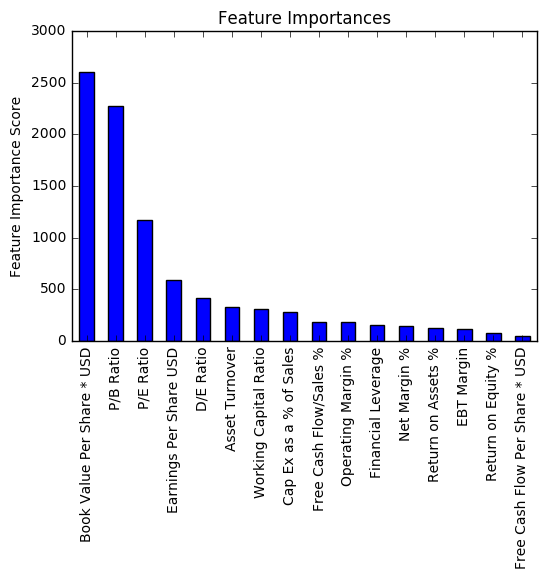

In [14]:
#seems equivalent to model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

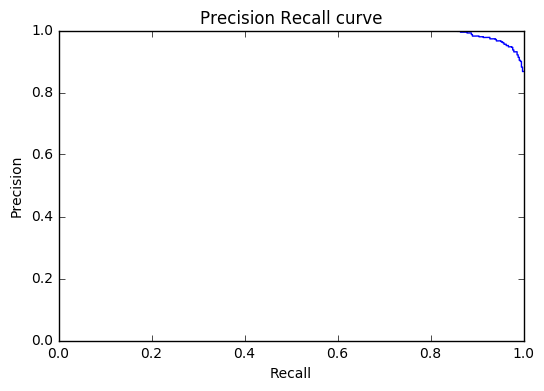

In [15]:
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

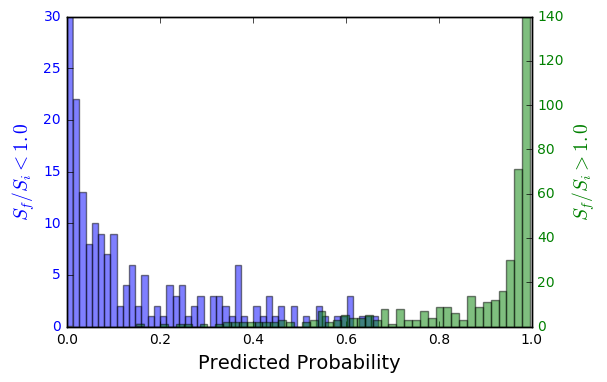

In [16]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]

fig, ax1 = plt.subplots()
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('$S_f/S_i<%.1f$'%true_threshold,  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('$S_f/S_i>%.1f$'%true_threshold, fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

# Extra

(-5, 5)

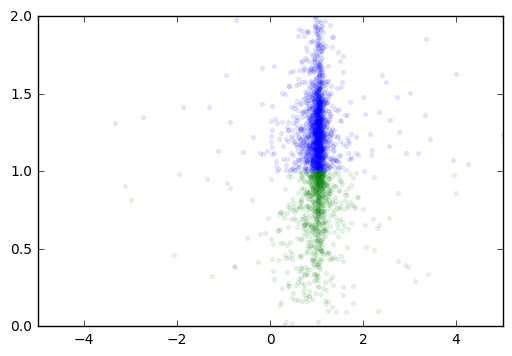

In [30]:
feature="Book Value Per Share * USD"
plt.plot(X.loc[y==1,feature], X.loc[y==1,"Mean Future Fractional Price Change"], '.', alpha=0.1)
plt.plot(X.loc[y==0,feature], X.loc[y==0,"Mean Future Fractional Price Change"], '.', alpha=0.1)
plt.ylim([0,2])
plt.xlim([-5,5])

Testing

In [ ]:
path = "Fundamental_Analysis/"
skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR','CZK']
del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
stock="A"
d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
d = d.transpose().reset_index()
#date = d['index'].values
#i1,i2 = np.where(d['index'].str.contains("%d"%year))[0][0], np.where(d['index'].str.contains("%d"%(year-1)))[0][0]
#ratios = d.iloc[i1].convert_objects(convert_numeric=True)/d.iloc[i2].convert_objects(convert_numeric=True)
#d = pd.DataFrame(ratios).transpose()
#d.insert(0,'Stock',stock)                              #keep stock ticker
#d.insert(1,'Mean Fractional Price Change',get_mean_frac_price_change(stock,date)) #get fractional price change
l=pd.to_numeric(d.iloc[0], errors='coerce')/pd.to_numeric(d.iloc[1], errors='coerce')
l

In [ ]:
i1=np.where(d['index'].str.contains("%d"%year))[0][0]
date=d['index'].iloc[i1]
get_mean_frac_price_change("ABCB",date)

In [ ]:
plt.plot(X['Earnings Per Share USD'],X['Mean Fractional Price Change'], '.',alpha=0.05)
plt.xlim([-5,5])
plt.ylim([0,4])

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [ ]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [ ]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [ ]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [ ]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()